In [2]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

importation de donnees

In [3]:
df=pd.read_excel("FS_DATA_DAS.xlsx")
df

,Date,Recettes,Change,IPC
0,1998-10-01,4.511900e+08,16.3043,7.497835
1,1998-11-01,3.793800e+08,16.5948,8.022774
2,1998-12-01,3.967000e+08,16.5046,7.447713
3,1999-01-01,4.376500e+08,16.7778,7.375875
4,1999-02-01,4.147200e+08,16.8943,7.932369
...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000
308,2024-06-01,6.102811e+09,132.2823,28.900000
309,2024-07-01,4.995281e+09,131.7522,30.000000
310,2024-08-01,4.843745e+09,131.5083,29.300000


differenciation premiere de toutes les series

In [4]:
# Différenciation simple (1re différence)
df['dRecettes'] = df['Recettes'] - df['Recettes'].shift(1)
df['dIPC'] = df['IPC'] - df['IPC'].shift(1)
df['dChange'] = df['Change'] - df['Change'].shift(1)


# Supprimer la première ligne (valeurs manquantes)
df_model = df.dropna()

df_model

,Date,Recettes,Change,IPC,dRecettes,dIPC,dChange
1,1998-11-01,3.793800e+08,16.5948,8.022774,-7.181000e+07,0.524939,0.2905
2,1998-12-01,3.967000e+08,16.5046,7.447713,1.732000e+07,-0.575061,-0.0902
3,1999-01-01,4.376500e+08,16.7778,7.375875,4.095000e+07,-0.071838,0.2732
4,1999-02-01,4.147200e+08,16.8943,7.932369,-2.293000e+07,0.556494,0.1165
5,1999-03-01,4.629400e+08,16.6816,7.941816,4.822000e+07,0.009447,-0.2127
...,...,...,...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000,-6.952860e+06,1.000000,0.2144
308,2024-06-01,6.102811e+09,132.2823,28.900000,1.128319e+09,0.600000,-0.2314
309,2024-07-01,4.995281e+09,131.7522,30.000000,-1.107530e+09,1.100000,-0.5301
310,2024-08-01,4.843745e+09,131.5083,29.300000,-1.515362e+08,-0.700000,-0.2439


calcul du meilleur modele

In [5]:
# ⚠️ Assurer que l'index est en datetime
df.index = pd.to_datetime(df.index)

# ⚠️ Garder uniquement les colonnes nécessaires et supprimer les NaNs
df = df[['dRecettes', 'dIPC', 'dChange']].dropna()

# 🔀 Séparer les données en train et test (par exemple, les 12 derniers mois pour test)
train = df[:-12]
test = df[-12:]

# 🔢 Définir les séries pour SARIMAX
y_train = train['dRecettes']
exog_train = train[['dIPC', 'dChange']]

y_test = test['dRecettes']
exog_test = test[['dIPC', 'dChange']]

stepwise_model = auto_arima(
    y=y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=12830.231, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12975.345, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12875.507, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12850.455, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12973.474, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=12847.806, Time=0.46 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=12837.217, Time=0.63 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=12830.049, Time=1.33 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=12829.855, Time=1.25 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=12830.091, Time=1.06 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=12834.418, Time=0.81 sec
 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=12831.361, Time=1.36 sec
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=12826.679, Time=1.74 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(2,0,

Estimer le modele avec les variables exogenes

In [6]:
# ⚠️ Ton y_train, exog_train, y_test, exog_test doivent être déjà définis

# Définir et ajuster le modèle
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 0, 5),         # Tu peux adapter ces valeurs
    seasonal_order=(1, 0, 1, 12),  # Pour la saisonnalité mensuelle
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())



c:\Users\kensc\Downloads\COURSERA\PYTHON\ProjetArima\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
c:\Users\kensc\Downloads\COURSERA\PYTHON\ProjetArima\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                            dRecettes   No. Observations:                  299
Model:             SARIMAX(2, 0, 5)x(1, 0, [1], 12)   Log Likelihood               -6007.368
Date:                              Thu, 26 Jun 2025   AIC                          12038.737
Time:                                      16:41:58   BIC                          12082.397
Sample:                                  01-01-1970   HQIC                         12056.247
                                       - 01-01-1970                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dIPC       -8.268e+06   2.28e-09  -3.63e+15      0.000   -8.27e+06   -8.27e+06
dChange    -4.061e+

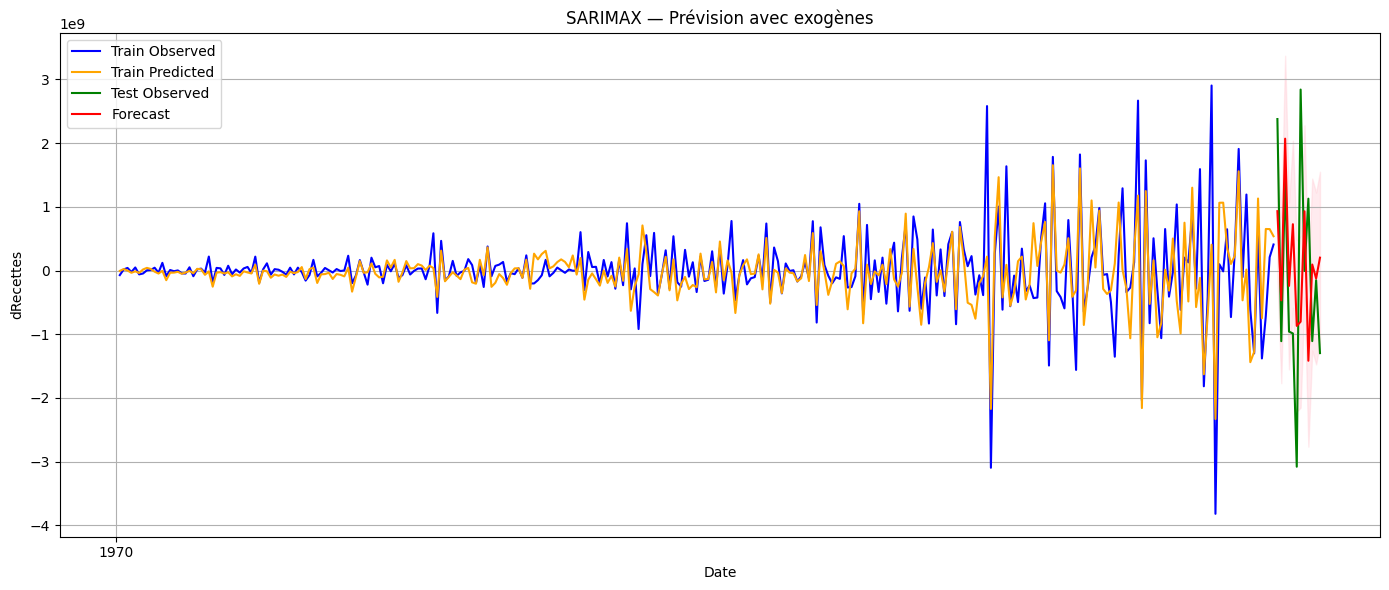

In [7]:
# Prédictions sur l'ensemble de test
forecast = results.get_forecast(steps=12, exog=exog_test)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

# Prédictions sur l'entraînement
train_pred = results.fittedvalues

# Tracer
plt.figure(figsize=(14,6))
plt.plot(y_train, label='Train Observed', color='blue')
plt.plot(train_pred, label='Train Predicted', color='orange')
plt.plot(y_test, label='Test Observed', color='green')
plt.plot(pred_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX — Prévision avec exogènes')
plt.xlabel('Date')
plt.ylabel('dRecettes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Statistiques descriptive des variable exogene

In [8]:
print(exog_train.describe())


             dIPC     dChange
count  299.000000  299.000000
mean     0.081278    0.396079
std      1.631566    3.521041
min     -6.968932  -50.501900
25%     -0.587531    0.000000
50%      0.100000    0.242100
75%      0.691961    0.762460
max      8.500000   12.493300


matrice de correlation entre les variables exogene

In [29]:
print(exog_train.corr())


             dIPC   dChange
dIPC     1.000000  0.187552
dChange  0.187552  1.000000


Que signifie ce résultat ?
La corrélation entre dIPC et dChange est de 0.188, ce qui est :

Faible, mais positive ;

Cela signifie que lorsque l’inflation augmente légèrement, le taux de change a tendance à augmenter aussi, mais pas de manière forte ou systématique.

 Conséquences pour ton modèle
 Bonne nouvelle : une corrélation faible réduit le risque de multicolinéarité, donc tu peux utiliser les deux variables dans un modèle SARIMAX sans problème majeur.

 Si la corrélation avait été proche de 1 ou -1, il aurait fallu envisager :

De retirer une variable,

Ou de faire une combinaison (PCA, ratio, etc.).